In [86]:
#Necessary imports
from astropy.io import fits #used to open fits files in which data are stored
import pylab #plotting
import glob
mykepler = '2' #add here the source number assigned to you, '1' or '2'
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import LightCurveSimulator
from scipy.signal import medfilt
import pandas as pd
import matplotlib.pyplot as plt


First, we will have a look at the dataset, we have given you the fits dataset exactly as provided by Kepler, you can download additional datasets [on the Kepler archive](https://archive.stsci.edu/kepler/). We have though made the header anonymous so you cannot see which source you are working with. 

In [2]:
#Fits files are open like this:
lc = fits.open('Data/Object%slc/kplr%s_1.fits'%(mykepler, mykepler))

Fits files are common in astrophysics, they have different extensions, which can be images or tables. The information discribing the data is stored in the header.

In [3]:
#The header for the first extension can be accesses like this:
lc[0].header
#It contains basic information about the object (some of those removed here)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-22'         / file creation date.                            
CREATOR = '911195 FluxExporter2PipelineModule' / pipeline job and program used t
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.24 r60387' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

**You will see some of the header keywords to read 'None of your business', this is because we have anonymized the dataset for you. 

In [4]:
#the data in the extension can be stored like this:
lc[0].data
#the first extension is empty, it just has the information

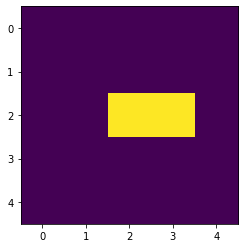

In [5]:
#The last extension holds a small image of the source:
lc[2].header
pylab.imshow(lc[2].data)

In [6]:
#lets have a look at the second extension
lc[1]
#This is a table extension

In [7]:
#Here the beginning has a description of columns in the table, including the units
lc[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                 4375 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

<ErrorbarContainer object of 3 artists>

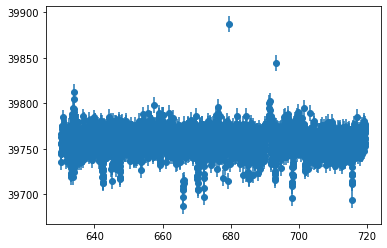

In [8]:
#Measurements errors are also included, you can plot them as follows
pylab.errorbar(lc[1].data['TIME'], lc[1].data['PDCSAP_FLUX'], lc[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')
#We'll need to zoom in to see them:

## Your turn: Preparing for fitting:

$\bullet$ locate all transits and make a plot for each

In [9]:
## So far, we have only looked at a subset of the data, the full dataset is stored in the Data folder.
glob.glob('Data/Object%slc/kplr*.fits'%(mykepler)) #Lists all your lightcurve files


['Data/Object2lc/kplr2_11.fits',
 'Data/Object2lc/kplr2_1.fits',
 'Data/Object2lc/kplr2_10.fits',
 'Data/Object2lc/kplr2_17.fits',
 'Data/Object2lc/kplr2_7.fits',
 'Data/Object2lc/kplr2_6.fits',
 'Data/Object2lc/kplr2_16.fits',
 'Data/Object2lc/kplr2_9.fits',
 'Data/Object2lc/kplr2_5.fits',
 'Data/Object2lc/kplr2_15.fits',
 'Data/Object2lc/kplr2_14.fits',
 'Data/Object2lc/kplr2_4.fits',
 'Data/Object2lc/kplr2_8.fits',
 'Data/Object2lc/kplr2_3.fits',
 'Data/Object2lc/kplr2_13.fits',
 'Data/Object2lc/kplr2_12.fits',
 'Data/Object2lc/kplr2_2.fits']

## Plot full light curve

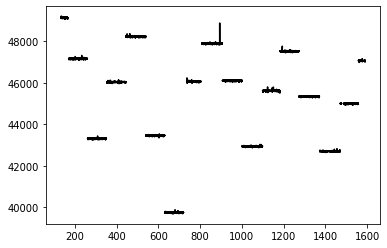

In [10]:
#THis works....
for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    pylab.plot(tmptime, tmpflux, c='k')

# Modelling

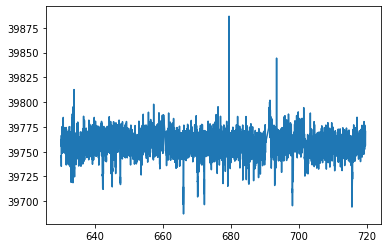

In [11]:
t = lc[1].data['TIME']
f = lc[1].data['PDCSAP_FLUX']

#remove nans
nonan = ~np.isnan(f)
t = t[nonan]
f = f[nonan]

#plot
pylab.plot(t, f)

## Savitzky-Golay

This is a kind of filter that fits polynomials locally to the data. It can be used to smooth data. See the [scipy implimentation](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html).

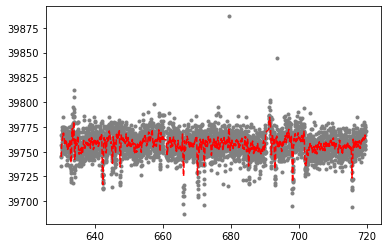

In [12]:
interp_savgol = savgol_filter(f, window_length=41, polyorder=4)
#windowlength is the length of the window over which the polynomial will be fit, polyorder is the order of the polynimial to be fit

pylab.plot(t, f, ls='None', marker='.', c='grey', label='Data')
pylab.plot(t, interp_savgol, ls='--', c='r', label='Savitzky Golay w=11,o=3')
#pylab.xlim(660,670)

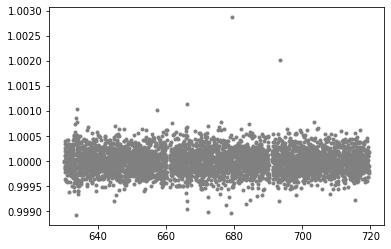

In [13]:
#plot normalised dataset
pylab.plot(t, f/interp_savgol, ls='None', marker='.', c='grey', label='Data')
#pylab.xlim(661,665)

## SssSSSSSSSSSSssspline

In [14]:
tnew = np.arange(630, 720, 1)
tnew.dtype

dtype('int64')

In [15]:
newfl = interpolate.BSpline(t, f, 1, axis = 0)

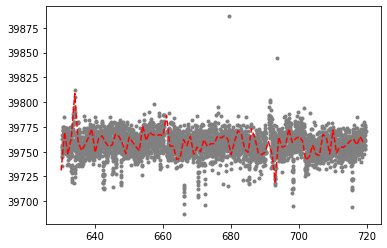

In [16]:
pylab.plot(t, f, ls='None', marker='.', c='grey', label='Data')
pylab.plot(tnew, newfl(tnew), ls='--', c='r', label='Spline')
#pylab.xlim(660,670)

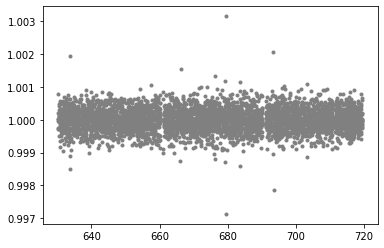

In [17]:
#plot normalised dataset
pylab.plot(t, f/newfl(t), ls='None', marker='.', c='grey', label='Data')
#pylab.xlim(661,665)

## median filter 

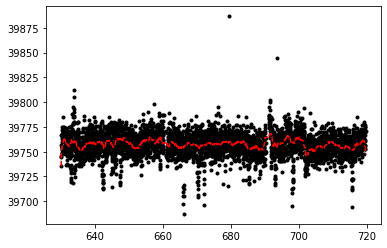

In [18]:
testfil = medfilt(f, kernel_size=75) ##kernel_size is the size of the window over which the median is calculated 
pylab.plot(t, f, c='k', ls='None', marker='.', label='Data')
pylab.plot(t, testfil, ls='--', c='r', label='Median Filter')

(641, 644)

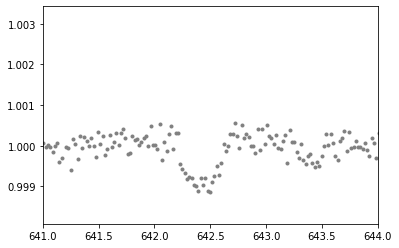

In [19]:
pylab.plot(t, f/testfil, ls='None', marker='.', c='grey', label='Data')
pylab.xlim(641,644)

# Apply to entire dataset

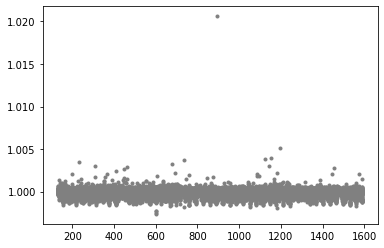

In [20]:
full_dataset_t = []
full_dataset_flux = [] 
full_dataset_error = []     ######## double check how errors propogate!

for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    t = tmp[1].data['TIME']
    flux_raw = tmp[1].data['PDCSAP_FLUX']
    error = tmp[1].data['PDCSAP_FLUX_ERR']

    #remove nans
    nonan = ~np.isnan(flux_raw)
    t = t[nonan]
    flux_raw = flux_raw[nonan]
    error = error[nonan]

    #plot
    testfil = medfilt(flux_raw, kernel_size=75) ##kernel_size is the size of the window over which the median is calculated 
    flux_normalised = flux_raw/testfil
    
    pylab.plot(t, flux_normalised, ls='None', marker='.', c='grey', label='Data')
    
    full_dataset_t.extend(t)
    full_dataset_flux.extend(flux_normalised)
    full_dataset_error.extend(error)
    


In [95]:
full_data = pd.DataFrame({'t':full_dataset_t, 'flux':full_dataset_flux, 'error': full_dataset_error})

In [96]:
csv_df = full_data.rename(columns = {'t':'#JD','flux' : 'mag'})
csv_df.to_csv('normalised_dataset.csv')

In [82]:
#Average time between samples 0.0245 days = 34.56 mins
full_data['t'].max() / full_data.shape[0]

0.024553621051283194

# Lomb-Scargle Periodograms

In [31]:
freqs = np.linspace((1/45.),(1/0.007), 1000)
import scipy.signal
from scipy.signal import lombscargle
lomb = scipy.signal.lombscargle(full_data['t'], full_data['flux'], freqs, precenter=True)

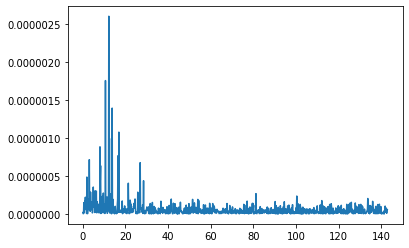

In [32]:
pylab.plot(freqs, lomb)

(0, 20)

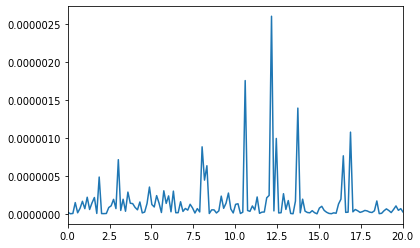

In [55]:
pylab.plot(freqs, lomb)
pylab.xlim(0,20)

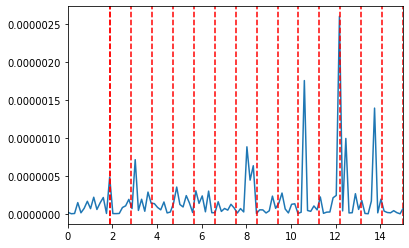

In [69]:
pylab.plot(freqs, lomb)
pylab.xlim(0,15)
actper = 1.88 ## the actual period
pylab.axvline(actper, c='r', ls = '--') ## indicating the actual period

for i in np.arange(1,10,0.5):
    pylab.axvline(actper*i, c='r',ls = '--' )

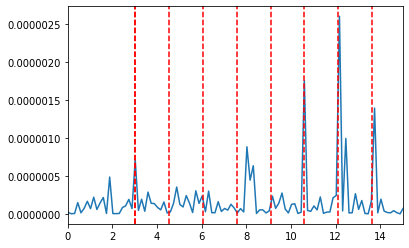

In [68]:
pylab.plot(freqs, lomb)
pylab.xlim(0,15)
actper = 3.03 ## the actual period
pylab.axvline(actper, c='r', ls = '--') ## indicating the actual period

for i in np.arange(1,10,0.5):
    pylab.axvline(actper*i, c='r',ls = '--' )

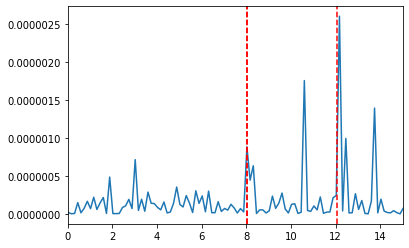

In [74]:
pylab.plot(freqs, lomb)
pylab.xlim(0,15)
actper = 8.05 ## the actual period
pylab.axvline(actper, c='r', ls = '--') ## indicating the actual period

for i in np.arange(1,10,0.5):
    pylab.axvline(actper*i, c='r',ls = '--' )

# Fold dataset

In [98]:
def fold_lightcurve(filename, period, *args, **kwargs):
    obj_name = kwargs.get('obj_name', None)
    outdata = kwargs.get('output_file', 'folded_lc_data.csv')
    plotname = kwargs.get('plot_file', 'folded_lc.pdf')
    
    ## Read in the data. Should be comma separated, header row (if present) should have # at the start.
    data = pd.read_csv(filename, usecols=[0,1,2], names=('JD', 'mag', 'error'), comment='#')
        
    if len(data.columns) < 3:
        print("File format should be \n\
              (M)JD, magnitude, uncertainty\n")
        exit(1)
    ## Folding the lightcurve:
    ## Phase = JD/period - floor(JD/period)
    ## The floor function is there to make sure that the phase is between 0 and 1.
    
    data['Phase'] = data.apply(lambda x: ((x.JD/ period) - np.floor(x.JD / period)), axis=1)
    
      
    ## Now make the plot
    
    plt.clf()
    plt.figure(figsize=(10,5))
    
    ## concatenating the arrays to make phase -> 0 - 3
    ## This makes it easier to see if periodic lightcurves join up as expected
    
    phase_long = np.concatenate((data.Phase, data.Phase + 1.0, data.Phase + 2.0))
    mag_long = np.concatenate((data.mag, data.mag, data.mag))
    err_long = np.concatenate((data.error, data.error, data.error))
    
    plt.errorbar(phase_long, mag_long, yerr=err_long, marker='o', ls='None', zorder=4, label='_nolegend_', mec='Grey')
    ## Inverting the y axis because magnitudes
    plt.gca().invert_yaxis()
    
    plt.xlabel('Phase ($\phi$)')
    plt.ylabel('Magnitude')
    
    ## making the plot title to include object and period. 
    ## If no object name given in kwargs then title is just period
    if obj_name != None:
        namestring = str(obj_name) + ', '
    else:
        namestring = ''
    titletext = namestring + 'P = ' + str(np.around(period, decimals=4)) + 'd'
    plt.suptitle(titletext)
    
    plt.savefig(plotname)
    
    ## Printing the phased data to a csv file.
    ## If filename not given in fold_lightcurve arguments default filename is folded_lc_data.csv
    
    data.to_csv(outdata, header=True, index=False, sep=',')

    
    return outdata


'folded_lc_data.csv'

<Figure size 432x288 with 0 Axes>

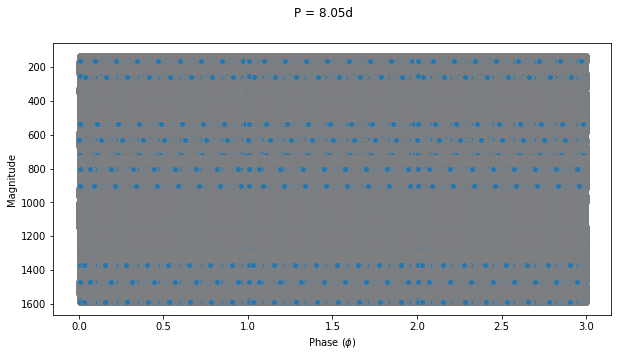

In [100]:
fold_lightcurve('normalised_dataset.csv', 8.05)